In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### x/w5/L5-mlp-dip-iitm

# Multiclass Classifier (OneVsAll)
- We know that the perceptron is a binary classifier. However, MNIST dataset contains 10 classes. Then how can we extend the idea to handle multi-class problems?
- **Solution**: Combine multiple binary classifiers and devise a suitable scoring metric.
- Sklearn makes it extremely easy without modifying a single line of code that we have written for the binary classifier.
- Sklearn does this by counting a number of unique elements (10 in this case) in the label vector y_train and converting labels using LabelBinarizer to fit each binary classifier(Remember binary classifier requires binary labels, Tautology:-))


In [2]:
# Common imports 
import numpy as np
import os
import io
import warnings

# sklearn specific imports
from sklearn.datasets import fetch_openml

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import Perceptron

from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV

from pprint import pprint

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# it returns Data and label as a pandas dataframe

In [5]:
X = X.to_numpy()
y = y.to_numpy()

In [6]:
target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0], type(X)))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum: {0}, Maximum:{1}'.format(np.min(X), np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names), y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:<class 'numpy.ndarray'>
Number of features: 784
Minimum: 0.0, Maximum:255.0
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [7]:
X = MinMaxScaler().fit_transform(X)
print("Minimum:{0}, Maximum:{1}".format(np.min(X), np.max(X)))

Minimum:0.0, Maximum:1.0


In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

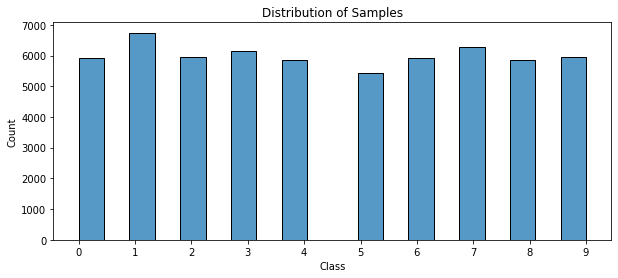

In [9]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2, 3, 4, 5, 6, 7, 8, 9], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

### Modifying labels

- Let us start with a simple classification problem, that is, binary classification.
- Since the original label vector contains 10 classes, we need to modify the number of classes to 2.
- Therefore, the label 0 will be changed to 1 and all other labels(1-9) will be changed to -1.
- We name the label vectors as `y_train_0` and `y_test_0`.

In [10]:
# Initialize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train == '0') # remember original labels are of type str not int
# use those indices to modify y_train_0 & y_test_0
y_train_0[indx_0] =1
indx_0 = np.where(y_test=='0')
y_test_0[indx_0] = 1

In [11]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer

In [12]:
clf = Perceptron(random_state=1729)

In [13]:
# Let's use label binarizer just to see the encoding
y_train_ovr = LabelBinarizer().fit_transform(y_train) # setting sparse_output=True in LabelBinarizer() improves efficiency
for i in range(10):
    print('{0}:{1}'.format(y_train[i], y_train_ovr[i]))

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


- The `y_train_ovr` will be of size of size 60000 x 10.
- The first column will be a (binary) label vector for 0-detector and the next one for 1-detector and so on.

In [14]:
clf.fit(X_train, y_train)

Perceptron(random_state=1729)

- What had actually happened internally was the API automatically created 10 binary classifiers, converted labels to binary sparse matrix and trained them with the binarized labels!
- During the inference time, the input will be passed through all these 10 classifiers and the highest score among the output from the classifiers will be considered as the predicted class.
- To see it in action, let us execute the following lines of code.

In [15]:
print('Shape of Weight matrix:{0} and bias vector:{1}'.format(clf.coef_.shape, clf.intercept_.shape))

Shape of Weight matrix:(10, 784) and bias vector:(10,)


- So it is a matrix of size 10 X 784 where each row represents the weights for a single binary classifier.
- Important difference to note is that there is no signum function associated with the perceptron.
- The class of a perceptron that outputs the maximum score for the input sample is considered as the predicted class.

In [16]:
scores = clf.decision_function(X_train[6].reshape(1, -1))
print(scores)
print('The predicted class: ', np.argmax(scores))

[[-631.88492118  154.366213    -65.23234141  -90.95338716 -189.29568627
  -137.14385236  -99.64604383 -159.09859285 -136.86391388 -199.26120723]]
The predicted class:  1


In [17]:
print('Predicted output:\n')
print(clf.predict(X_train[0].reshape(1,-1)))

Predicted output:

['5']


In [18]:
# get the prediction for all training samples
y_hat = clf.predict(X_train)

In [19]:
print(classification_report(y_train, y_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5923
           1       0.94      0.98      0.96      6742
           2       0.89      0.90      0.90      5958
           3       0.86      0.87      0.87      6131
           4       0.89      0.94      0.91      5842
           5       0.81      0.88      0.85      5421
           6       0.92      0.97      0.94      5918
           7       0.91      0.94      0.92      6265
           8       0.92      0.77      0.84      5851
           9       0.92      0.82      0.87      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



Let's display the confusion matrix and relate it with the report above.

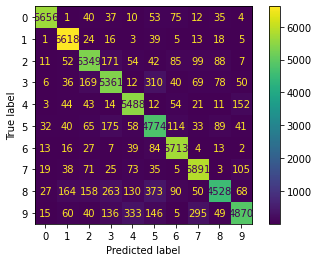

In [20]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat,
                                            values_format='.5g') # it returns matplotlib plot object

- Digit 2 is often confused with digit 3 (Reasonable).

## Making a Pipeline

- Let's create a pipeline to keep the code compact.
- Recall that, the MNIST dataset is clean and hence doesn't require preprocessing.
- The one potential preprocessing technique we may use is to scale the features within the range(0, 1).
- It is not similiar to scaling down the range values between 0 and 1.

In [21]:
# create a list with named tuples
estimators = [('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())]
pipe = Pipeline(estimators)

In [22]:
pipe.fit(X_train, y_train_0)

Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

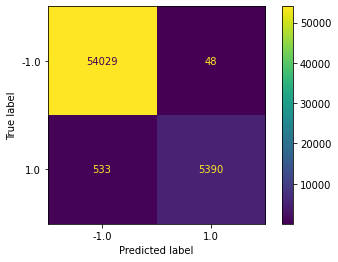

In [23]:
y_hat_train_0 = pipe.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,
                                    y_hat_train_0, values_format='.5g')
plt.show()

## Iteration vs Loss curve
The other way of Plotting Iteration Vs Loss curve with the `Partial_fit` method.

In [24]:
iterations = 100
bin_clf1 = Perceptron(max_iter=1000,random_state=2094)
Loss_clf1 = []
for i in range(iterations):
    bin_clf1.partial_fit(X_train, y_train_0, classes=np.array([1,-1]))
    y_hat_0 = bin_clf1.decision_function(X_train)
    Loss_clf1.append(hinge_loss(y_train_0, y_hat_0))

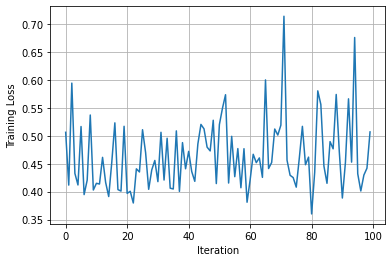

In [25]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

## GridSearchCV
- So far we didn't do any hyperparameter tuning. We accepted the default value for learning rate of the Perceptron class.
- Now, let us search for a better learning rate using `GridSearchCV'.
- No matter what the learning rate is, the loss will never converge to zero as the classes are not linearly separable.

In [26]:
scoring = make_scorer(hinge_loss, greater_is_better=False)
lr_grid = [1/2**n for n in range(1, 6)]
bin_clf_gscv = GridSearchCV(Perceptron(), param_grid={"eta0":lr_grid}, scoring=scoring, cv=5)
bin_clf_gscv.fit(X_train, y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [27]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.02429075, 1.07795815, 0.97945514, 0.89156446, 0.7794827 ]),
 'mean_score_time': array([0.02239485, 0.0212173 , 0.02105165, 0.02184625, 0.02104607]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5], dtype=int32),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.

As we can see, the best learning rate is 0.125

In [28]:
iterations = 100
Loss = []
best_bin_clf = Perceptron(max_iter=1000,random_state=2094,eta0=0.125)
for i in range(iterations):
    best_bin_clf.partial_fit(X_train, y_train_0, classes=np.array([1, -1]))
    y_hat_0 = best_bin_clf.decision_function(X_train)
    Loss.append(hinge_loss(y_train_0, y_hat_0))
    

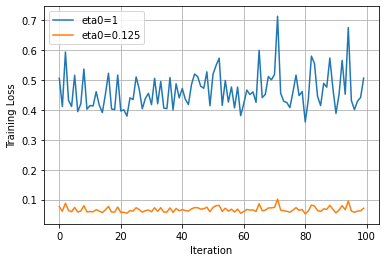

In [29]:
plt.figure()
plt.plot(np.arange(iterations), Loss_clf1,label='eta0=1')
plt.plot(np.arange(iterations),Loss,label='eta0=0.125')
plt.grid(True)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

Well, instead of instantiating a Perceptron class with a new learning rate and re-train the model, we could get the best_estimator from `GridSearchCV` as follows.

In [30]:
best_bin_clf = bin_clf_gscv.best_estimator_

In [31]:
y_hat_train_0 = best_bin_clf.predict(X_train)
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99     54077
         1.0       0.95      0.95      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.99      0.99      0.99     60000



Compare the classification report when eta0=1

## Visualizing weight vectors

It will be interesting to look into the samples which are misclassified as False Positives(that is, images that are not zero but classified as zero), and come up with some possible reasons, Shall we do it?

In [32]:
# repeating the code for readability
bin_clf = Perceptron(max_iter=100)
bin_clf.fit(X_train, y_train_0)
y_hat_train_0 = bin_clf.predict(X_train)

In [33]:
# find the index of false positive samples
idx_n = np.where(y_train_0 == -1) # index of true -ve samples
idx_pred_p = np.where(y_hat_train_0==1) # index of predicted positive samples
idx_pred_n = np.where(y_hat_train_0==-1) # index of predicted negative samples
idx_fp = np.intersect1d(idx_n, idx_pred_p)
idx_tn = np.intersect1d(idx_n, idx_pred_n)

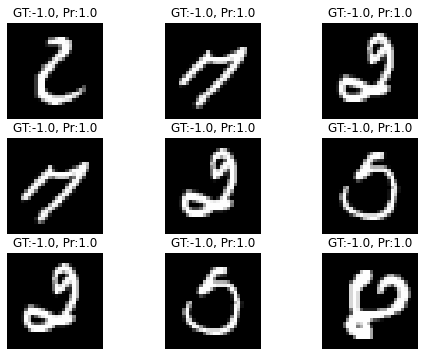

In [34]:
factor = 3
fig, ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8, 6))
idx_offset=0
for i in range(3):
    index = idx_offset+i
    for j in range(3):
        ax[i, j].imshow(X_train[idx_fp[index+j]].reshape(28,28),cmap='gray') # we should not use x_train_with_dummy
        ax[i, j].set_title('GT:{0}, Pr:{1}'.format(str(y_train_0[idx_fp[index+j]]),str(y_hat_train_0[idx_fp[index+j]])))
        ax[i, j].set_axis_off()

We can do some reasoning if we look into what the perceptron is actually learning about the digit 0 by visualizing the weight values after that training!

In [35]:
from matplotlib.colors import Normalize

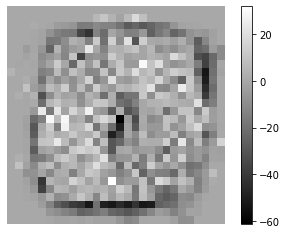

In [36]:
w = bin_clf.coef_
w_matrix = w.reshape(28, 28)
fig = plt.figure()
plt.imshow(w_matrix, cmap='gray')
plt.grid(False)
plt.axis(False)
plt.colorbar()
plt.show()

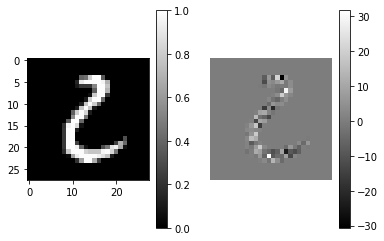

In [37]:
activation = w * X_train[idx_fp[0]].reshape(1, -1)
lin_out = activation.reshape(28, 28)
plt.subplot(1,2,1)
plt.imshow(X_train[idx_fp[0]].reshape(28,28),cmap='gray')
plt.colorbar()
# lin_out[lin_out<0]=0 # just set the value less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out,cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [38]:
# input to the signum
print(np.sum(lin_out) + bin_clf.intercept_)

[22.90520569]


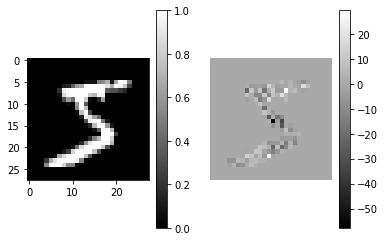

In [39]:
activation = w*X_train[idx_tn[0]].reshape(1, -1)
lin_out = activation.reshape(28, 28)
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx_tn[0]].reshape(28,28),cmap='gray')
plt.colorbar()
# lin_out[lin_out<0]=0 # just set the value less than zero to zero
plt.subplot(1,2,2)
plt.imshow(lin_out,cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [40]:
# input to signum
print(np.sum(lin_out) + bin_clf.intercept_)

[-293.33960784]
